<a href="https://colab.research.google.com/github/Satwikram/NLP-Implementations/blob/main/Quora%20Insincere%20BERT%20%2B%20Feature%20Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Author: Satwik Ram K

### Connecting to Kaggle

In [ ]:
from google.colab import files

files.upload()


! mkdir ~/.kaggle


! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


### Downloading dataset

In [ ]:
!kaggle competitions download -c quora-insincere-questions-classification

In [ ]:
!unzip /content/train.csv.zip
!unzip /content/test.csv.zip

In [ ]:
!pip install transformers

### Importing Dependencies

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFAutoModel
import os
from datetime import datetime
from pathlib import Path

from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, BatchNormalization, Input, Dropout
from tensorflow.keras.models import Model, load_model
import nltk

# nltk.download("stopwords")
# nltk.download("wordnet")

from nltk.corpus import stopwords
import re
import string

In [ ]:
dataset = pd.read_csv("/content/train.csv")

In [ ]:
dataset.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [ ]:
dataset = dataset.drop_duplicates(subset=['qid'], keep='first')

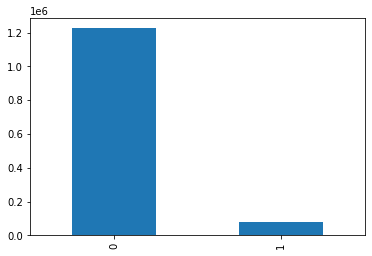

In [ ]:
dataset["target"].value_counts().plot(kind = "bar")

In [ ]:
dataset["target"].value_counts()

0    1225312
1      80810
Name: target, dtype: int64

In [ ]:
class_0 = dataset[dataset["target"]==0].sample(n=20000, replace=False)
class_1 = dataset[dataset["target"]==1].sample(n=20000, replace=False)

df = pd.concat([class_0, class_1])

df["target"].value_counts()

1    20000
0    20000
Name: target, dtype: int64

### Clean Text

In [ ]:
def clean_text(text):

  lem = nltk.stem.wordnet.WordNetLemmatizer()  # Lemmatization

  text = " ".join(map(lambda x: lem.lemmatize(x), text.split()))

  text = re.sub("\s+", " ", text)  # Remove extra spaces

  return text

In [ ]:
df["question_text"] = df["question_text"].apply(clean_text)

### Feature Engineering

In [ ]:
def add_features(df, column):

  def count_punct(text):

    count = sum([1 for char in text if char in string.punctuation])
    return round(count / (len(text) - text.count(" ")), 3) * 100

  def count_stopwords(text):

    count = sum([1 for word in text.split() if word in stopwords.words("english")])
    return round(count / len(text.split()), 3) * 100

  def average_length(text):

    word = text.split()
    len_char = [len(c) for c in word]
    average = sum(len_char) / len(word)
    return average

  def count_vowels(text):

    count = sum([1 for char in text if char in ["a", "e", "i", "o", "u"]])
    return round(count / (len(text) - text.count(" ")), 3) * 100

  def count_articles(text):

    count = sum([1 for word in text.split() if word in ["a", "the", "an"]])
    return round(count / (len(text.split())), 3) * 100

  df["length"] = df[column].apply(lambda x: len(x) - x.count(" "))
  df["Number of words"] = df[column].apply(lambda x: len(x.split()))
  df["punct%"] = df[column].apply(lambda x: count_punct(x))
  df["stopwords%"] = df[column].apply(lambda x: count_stopwords(x))
  df["Average length of words"] = df[column].apply(lambda x: average_length(x))
  df["vowel%"] = df[column].apply(lambda x: count_vowels(x))
  df["article%"] = df[column].apply(lambda x: count_articles(x))

  return df

In [ ]:
df = add_features(df, "question_text")

In [ ]:
df.head()

,qid,question_text,target,length,Number of words,punct%,stopwords%,Average length of words,vowel%,article%
99597,1380c98defe62e563121,How often do blackbird lay eggs?,0,27,6,3.7,16.7,4.500000,29.6,0.0
317702,3e439b3cfceb568c3946,What were Jiddu Krishnamurti's literary influe...,0,46,6,4.3,16.7,7.666667,34.8,0.0
715948,8c26cd4baa8400425913,I own two Instagram accounts. Is there any way...,0,78,19,2.6,47.4,4.105263,34.6,10.5
651650,7fa35316e8557092e11f,What is life like in a Texas police academy?,0,36,9,2.8,33.3,4.000000,44.4,11.1
1201736,eb86101831cd96c291cf,What is an important lesson you can learn by r...,0,70,14,4.3,35.7,5.000000,37.1,7.1


In [ ]:
df.describe()

,target,length,Number of words,punct%,stopwords%,Average length of words,vowel%,article%
count,40000.000000,40000.000000,40000.000000,40000.00000,40000.000000,40000.000000,40000.000000,40000.000000
mean,0.500000,68.461575,14.842900,3.14875,35.506153,4.657078,35.823068,6.283458
std,0.500006,40.252286,8.618662,1.98207,11.851916,0.784889,4.213654,6.588928
min,0.000000,1.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,39.000000,9.000000,2.00000,28.600000,4.137931,33.300000,0.000000
50%,0.500000,56.000000,12.000000,2.70000,36.800000,4.600000,36.000000,5.600000
75%,1.000000,87.000000,19.000000,3.80000,43.800000,5.100000,38.500000,11.100000
max,1.000000,292.000000,56.000000,47.40000,72.700000,17.000000,57.100000,44.400000


### Tokenization

In [ ]:
pretrained_model = "bert-base-uncased"
sequence_length = 128
batch_size = 64
epochs=30

tokenizer = BertTokenizer.from_pretrained(pretrained_model)

tokens = tokenizer(
    df["question_text"].tolist(),
    max_length=sequence_length,
    truncation=True,
    padding="max_length",
    add_special_tokens=True,
    return_tensors="np"
)

df["Xids"] = tokens["input_ids"].tolist()
df["Xmasks"] = tokens["attention_mask"].tolist()

### Preparing inputs and outputs

In [ ]:
X = df.drop(columns=["question_text", "qid", "target"])
y = df["target"]

### Train Test

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
X_train_ids = np.vstack(X_train["Xids"])
X_train_mask = np.vstack(X_train["Xmasks"])
X_train_inputs = X_train.drop(columns=["Xids", "Xmasks"]).values

X_test_ids = np.vstack(X_test["Xids"])
X_test_mask = np.vstack(X_test["Xmasks"])
X_test_inputs = X_test.drop(columns=["Xids", "Xmasks"]).values

### Building BERT Model

In [ ]:
bert = TFAutoModel.from_pretrained("bert-base-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
inputs

<KerasTensor: shape=(None, 7) dtype=int32 (created by layer 'inputs')>

In [ ]:
input_ids = tf.keras.layers.Input(shape = (sequence_length,), name = "input_ids",
                                  dtype = "int32")

mask = tf.keras.layers.Input(shape = (sequence_length,), name = "attention_mask",
                                  dtype = "int32")

inputs = tf.keras.layers.Input(shape = X_train_inputs[0].shape, name = "inputs",
                                  dtype = "int32")

embeddings = bert(input_ids, attention_mask = mask)[0]
                                    
x1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences = True))(embeddings)
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(x1)
x1 = tf.keras.layers.Dense(64, activation="relu")(x1)

x2 = tf.keras.layers.Dense(256, activation="relu")(inputs)
x2 = tf.keras.layers.BatchNormalization()(x2)
x2 = tf.keras.layers.Dense(128, activation="relu")(x2)
x2 = tf.keras.layers.Dense(64, activation="relu")(x2)

x = tf.concat([x1, x2], axis=-1)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)

y = tf.keras.layers.Dense(1, activation = "sigmoid", name = "outputs")(x)

model = tf.keras.Model(inputs = [input_ids, mask, inputs], outputs = y)

In [ ]:
model.layers[2].trainable = False

In [ ]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model_3 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 5e-5, decay = 1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.compile(optimizer = optimizer, loss = loss, metrics = [acc])

### Callbacks

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("models", monitor = "val_loss", save_best_only = True, 
                                                verbose = 1)

earlystopping = tf.keras.callbacks.EarlyStopping( monitor = "val_loss", verbose = 1, restore_best_weights = True,
                                                 patience = 2)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.2,
                              patience = 1, min_lr = 0.001, verbose = 1)

callbacks = [checkpoint, earlystopping, reduce_lr]

In [ ]:
history = model.fit([X_train_ids, X_train_mask, X_train_inputs], y_train, validation_data = ([X_test_ids, X_test_mask, X_test_inputs], y_test), epochs = 1, callbacks = callbacks)

1000/1000 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 00001: val_loss improved from inf to 0.00000, saving model to models


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1000/1000 [==============================] - 944s 929ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 5.0000e-05
